## Traction Analytics Prediction

### Methodology

1. Data Preparation
- Concat daily downloads of weekly article activities from NewsWhip
- Calculate percentage and absolute change of each article across days

2. Define labels
- Set gradient threshold and abs interaction value threshold
- For each article, build a linear regression model for the facebook interactions over time and obtain the gradient
- If the gradient > threshold | abs interaction count > threshold -> trending
- Else if the gradient < -threshold -> untrending
- Else -> neutral

3. EDA of labels
- Readjust threholds if necessary
- Under or oversampling if necessary

4. Deep learning pipeline (SetFit for Few Shot)
- Tokenise
- Train-test split : 80/20
- Model evaluation using precision, recall and F1
- Model comparison

### Data Preperation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast 

%matplotlib inline
plt.style.use('ggplot')
sns.set_theme()

In [2]:
# Read and perform basic data processing

df = pd.read_csv('data/combined_data_merged.csv')
df = df[['published', 'headline', 'summary', 'link', 'facebook_interactions', 'date_extracted']]
df['published'] = pd.to_datetime(df['published'])
df['date_extracted'] = pd.to_datetime(df['date_extracted'])
df = df.sort_values(by=['headline', 'published', 'date_extracted'], ascending=[False, True, True]).reset_index(drop=True)

df

,published,headline,summary,link,facebook_interactions,date_extracted
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,1351,2023-05-04
1,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,1452,2023-05-05
2,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,1634,2023-05-07
3,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,1683,2023-05-08
4,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,1708,2023-05-09
...,...,...,...,...,...,...
4885,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,784,2023-05-04
4886,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,868,2023-05-05
4887,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,1038,2023-05-07
4888,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,1070,2023-05-08


In [3]:
# Create a dataframe with unique articles only

df_unique = df.drop_duplicates(subset=['headline', 'published'], keep='first').reset_index(drop=True)
df_unique

,published,headline,summary,link,facebook_interactions,date_extracted
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,1351,2023-05-04
1,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,1336,2023-05-04
2,2023-05-06 14:00:36,â€˜She left an incredible legacy': Tributes po...,Ms Joyce Leong was nicknamed â€œSnail Queenâ€...,https://www.facebook.com/129011692114_10159192...,1229,2023-05-07
3,2023-05-07 08:47:55,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,He looks like he could use a hug. ðŸ¥¹,https://www.facebook.com/292279440975148_55879...,462,2023-05-09
4,2023-05-08 11:16:09,â€˜I was just super pumpedâ€™: Singapore's Sha...,"Calm but excited, emotionless yet ""super pumpe...",https://www.facebook.com/93889432933_101596191...,1416,2023-05-09
...,...,...,...,...,...,...
1329,2023-05-11 10:18:50,"#trending: Singaporean artist receives US$10,0...",Ms Tan was among 21 million people who partici...,https://www.facebook.com/147858757571_10160154...,1016,2023-05-13
1330,2023-05-10 11:15:58,#trending: Primary 3 mathematics question with...,Try solving this: Mrs Kim gave 5 kg of rice to...,https://www.facebook.com/147858757571_10160152...,1091,2023-05-12
1331,2023-05-09 10:30:01,#trending: Former SIA cabin crew offers explan...,A recent post in Reddit from a disgruntled SIA...,https://www.facebook.com/147858757571_10160150...,664,2023-05-12
1332,2023-05-15 10:02:01,#trending: Blackpink fans criticise fellow con...,Disgruntled fans of K-pop group Blackpink crit...,https://www.facebook.com/147858757571_10160162...,779,2023-05-16


In [4]:
# Calculate the absolute and percentage change in facebook interactions for each article

df['facebook_interactions_abs_change'] = df.groupby('link')['facebook_interactions'].diff().fillna(0)
df['facebook_interactions_pct_change'] = df.groupby('link')['facebook_interactions'].pct_change().fillna(0)
df

,published,headline,summary,link,facebook_interactions,date_extracted,facebook_interactions_abs_change,facebook_interactions_pct_change
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,1351,2023-05-04,0.0,0.000000
1,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,1452,2023-05-05,101.0,0.074759
2,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,1634,2023-05-07,182.0,0.125344
3,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,1683,2023-05-08,49.0,0.029988
4,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,1708,2023-05-09,25.0,0.014854
...,...,...,...,...,...,...,...,...
4885,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,784,2023-05-04,0.0,0.000000
4886,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,868,2023-05-05,84.0,0.107143
4887,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,1038,2023-05-07,170.0,0.195853
4888,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,1070,2023-05-08,32.0,0.030829


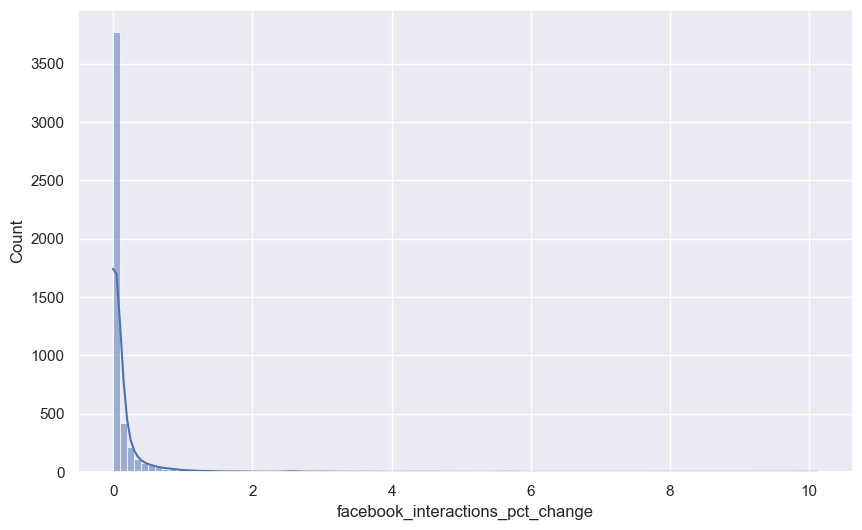

In [5]:
# plot histogram of facebook interactions pct change using seaborn

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='facebook_interactions_pct_change', bins=100, kde=True)
plt.show()


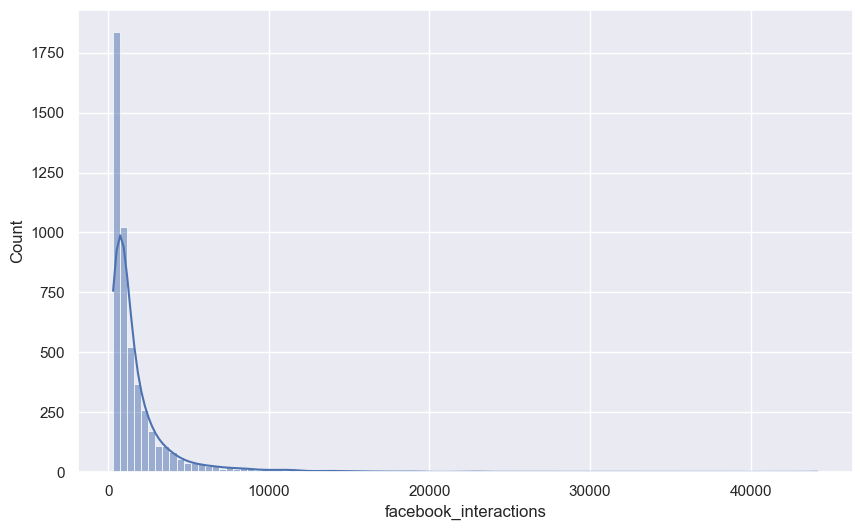

In [130]:
# plot histogram of facebook interactions pct change using seaborn

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='facebook_interactions', bins=100, kde=True)
plt.show()


#### Method 1: Using raw PCT change

Benefits:
- Considers daily spikes without smoothening
- Simple to explain

Issues:
- facebook interaction is cumulative
- no information about sustained increase of activity

In [6]:
# PCT_THRESHOLD = 0.10

In [7]:
# # Creating a custom group by function to determine if an article is trending, not trending or neutral based on the percentage change in facebook interactions

# def label_by_pct_change(pct_changes):
#     pct_changes = np.asarray(pct_changes)
#     label = 'neutral'
#     for pct_change in pct_changes:
#         if pct_change > PCT_THRESHOLD:
#             label = 'trending'
#         elif pct_change < -PCT_THRESHOLD:
#             label = 'not trending'
#     return label

# # Create a dataframe with unique articles and their corresponding labels

# df_labels = df.groupby('link')['facebook_interactions_pct_change'].agg(label_by_pct_change).reset_index()
# df_labels

#### Method 2: Using gradient within each article

Benefits:
- Smoothens based on weekly activities

Issues:
- Reduces impact of spikes
- Gradient threshold not very explainable

In [8]:
from sklearn.linear_model import LinearRegression

In [72]:
GRD_THRESHOLD = 0
VAL_ARR_THRESHOLD = 0

In [177]:
# Creating a custom group by function to determine if an article is trending, not trending or neutral based on the percentage change in facebook interactions

def label_by_LR(val_array):
    val_array = np.asarray(val_array)
    label = 'neutral'
    # scale val_array to be between 0 and 1
    val_array = (val_array - np.min(val_array)) / max((np.max(val_array) - np.min(val_array)), 0.000001)
    # replace nan values with 0
    val_array = np.nan_to_num(val_array)
    # build linear regression model for val_array array and obtain gradient
    model = LinearRegression()
    model.fit(np.arange(len(val_array)).reshape(-1, 1), val_array)
    gradient = model.coef_[0]
    
    if gradient > GRD_THRESHOLD or np.mean(val_array) > VAL_ARR_THRESHOLD:
        label = 'trending'

    # elif gradient < -GRD_THRESHOLD:
    #     label = 'not trending'

    return label


### Using Abs Values

<Axes: xlabel='label', ylabel='Count'>

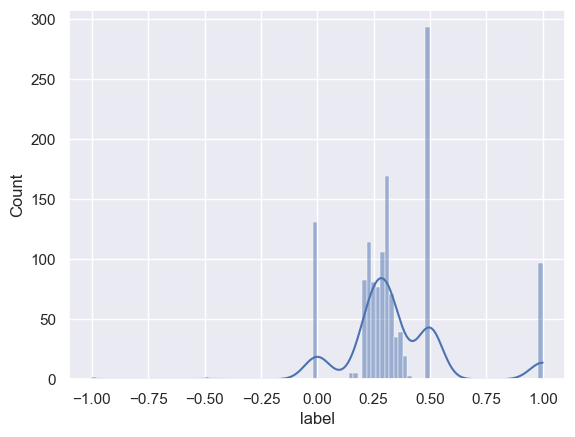

In [160]:
# sns.histplot(data=df_labelled, x='label', bins=100, kde=True)

In [244]:
GRD_THRESHOLD = 0.5
VAL_ARR_THRESHOLD = 0.7

In [245]:
# Create a dataframe with unique articles and their corresponding labels

df_labels = df.groupby('link')['facebook_interactions'].agg(label_by_LR).reset_index()

# Merge the unique articles dataframe with the labels dataframe

df_labelled = df_unique.merge(df_labels, on='link', how='left')
df_labelled = df_labelled.rename(columns={'facebook_interactions_x': 'facebook_interactions', 'facebook_interactions_y': 'label'})
df_labelled.head()

,published,headline,summary,link,facebook_interactions,date_extracted,label
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,1351,2023-05-04,neutral
1,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,1336,2023-05-04,neutral
2,2023-05-06 14:00:36,â€˜She left an incredible legacy': Tributes po...,Ms Joyce Leong was nicknamed â€œSnail Queenâ€...,https://www.facebook.com/129011692114_10159192...,1229,2023-05-07,neutral
3,2023-05-07 08:47:55,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,He looks like he could use a hug. ðŸ¥¹,https://www.facebook.com/292279440975148_55879...,462,2023-05-09,trending
4,2023-05-08 11:16:09,â€˜I was just super pumpedâ€™: Singapore's Sha...,"Calm but excited, emotionless yet ""super pumpe...",https://www.facebook.com/93889432933_101596191...,1416,2023-05-09,trending


### Using PCT Change

In [246]:
# GRD_THRESHOLD = 0.1
# VAL_ARR_THRESHOLD = 0.05

In [247]:
# # Create a dataframe with unique articles and their corresponding labels

# df_labels = df.groupby('link')['facebook_interactions_pct_change'].agg(label_by_LR).reset_index()
# df_labelled = df_unique.merge(df_labels, on='link', how='left')
# df_labelled = df_labelled.rename(columns={'facebook_interactions_pct_change': 'label'})
# df_labelled.head()

### EDA of target variables

In [248]:
# Perform basic data exploration of target variable

df_labelled['label'].value_counts()


neutral     864
trending    470
Name: label, dtype: int64

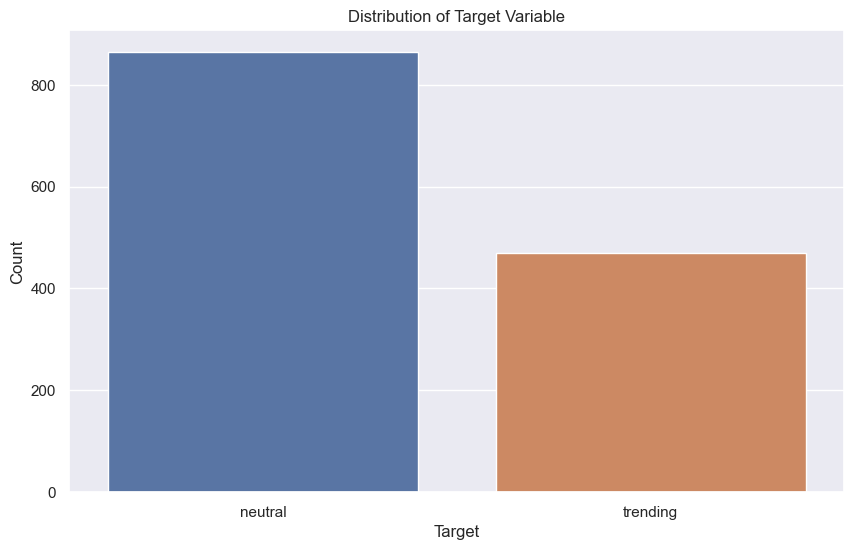

In [249]:
# Plot the distribution of target variable using Seaborn. 

plt.figure(figsize=(10, 6))
sns.countplot(data=df_labelled, x='label')
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [250]:
# previewing trending articles

df_labelled[df_labelled['label'] == 'trending']

,published,headline,summary,link,facebook_interactions,date_extracted,label
3,2023-05-07 08:47:55,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,He looks like he could use a hug. ðŸ¥¹,https://www.facebook.com/292279440975148_55879...,462,2023-05-09,trending
4,2023-05-08 11:16:09,â€˜I was just super pumpedâ€™: Singapore's Sha...,"Calm but excited, emotionless yet ""super pumpe...",https://www.facebook.com/93889432933_101596191...,1416,2023-05-09,trending
6,2023-05-11 00:30:02,â€˜I know what itâ€™s like to be homeless and ...,"Growing up without her mother around, Zulayqha...",https://www.facebook.com/93889432933_101596241...,1062,2023-05-12,trending
8,2023-05-16 01:00:10,â€˜Coffee Shop King' died of haemorrhage after...,"Mr Hoon Thing Leong, who owned coffee shop cha...",https://www.facebook.com/129011692114_10159210...,1516,2023-05-17,trending
15,2023-05-09 13:15:04,Zhen Zheng Handmade Pau: Stunning pork belly &...,Such a hidden gem ðŸ˜‹,https://www.facebook.com/345185573000_62360295...,859,2023-05-12,trending
...,...,...,...,...,...,...,...
1312,2023-05-19 12:37:44,'But you died in the 4th movie': Ip Man 5 is c...,"Donnie Yen announces a new Ip Man film, surpri...",https://www.facebook.com/121790674546188_64316...,441,2023-05-21,trending
1314,2023-05-10 05:22:31,"'Be right back, crying': 4D first prize slips ...",A woman in Singapore missed out on a 4D prize ...,https://www.facebook.com/121790674546188_64001...,762,2023-05-12,trending
1317,2023-05-09 07:16:35,'Anything you see of me is edited or fake': As...,"""It was pictures of me that I had posted fully...",https://www.facebook.com/121790674546188_63971...,4403,2023-05-12,trending
1327,2023-05-04 09:05:01,#trending: Teen reunites with SIA flight atten...,Over the course of the flight from London to S...,https://www.facebook.com/147858757571_10160140...,456,2023-05-05,trending


In [251]:
# previewing not trending articles

df_labelled[df_labelled['label'] == 'not trending']

,published,headline,summary,link,facebook_interactions,date_extracted,label


In [252]:
# concatenate headline and summary columns
df_labelled['text'] = df_labelled['headline'] + ' ' + df_labelled['summary']

### Deep Learning Pipeline

FewShot Learning using SetFit

In [253]:
from datasets import load_dataset, Features, Value
from sentence_transformers import SentenceTransformer
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



In [254]:
df_labelled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1334 entries, 0 to 1333
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   published              1334 non-null   datetime64[ns]
 1   headline               1334 non-null   object        
 2   summary                1334 non-null   object        
 3   link                   1334 non-null   object        
 4   facebook_interactions  1334 non-null   int64         
 5   date_extracted         1334 non-null   datetime64[ns]
 6   label                  1334 non-null   object        
 7   text                   1334 non-null   object        
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 93.8+ KB


In [255]:
df_train_test = df_labelled[['text', 'label']]
df_train_test

,text,label
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,neutral
1,â€˜The Godfather of AI' leaves Google and warn...,neutral
2,â€˜She left an incredible legacy': Tributes po...,neutral
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,trending
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,trending
...,...,...
1329,"#trending: Singaporean artist receives US$10,0...",neutral
1330,#trending: Primary 3 mathematics question with...,neutral
1331,#trending: Former SIA cabin crew offers explan...,trending
1332,#trending: Blackpink fans criticise fellow con...,neutral


In [256]:
label_mapper = {'trending': 1, 'not trending': -1, 'neutral': 0}
df_train_test['label'] = df_train_test['label'].map(label_mapper)

C:\Users\edmun\AppData\Local\Temp\ipykernel_21836\3810543172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test['label'] = df_train_test['label'].map(label_mapper)


In [257]:
# Train test split

# X_train, X_test, y_train, y_test = train_test_split(df_train_test['text'], df_train_test['label'], test_size=0.2, random_state=42, stratify=df_train_test['label'])
train_df, test_df = train_test_split(df_train_test, test_size=0.2, random_state=42, stratify=df_train_test['label'])

train_df.to_parquet('data/train_df.parquet')
test_df.to_parquet('data/test_df.parquet')

In [258]:
dataset = load_dataset("parquet", data_files={'train': "data/train_df.parquet", 'test': "data/test_df.parquet"})
train_dataset = dataset["train"]
test_dataset = dataset["test"]

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 994.85it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-2cd917c085e145e3/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 999.12it/s]


In [259]:
# Load a SetFit model
model = SetFitModel.from_pretrained(
    "sentence-transformers/multi-qa-MiniLM-L6-cos-v1", 
    cache_dir="cached_models",
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [260]:
# check if GPU is available
import torch
torch.cuda.is_available()

True

In [261]:
# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    loss_class=CosineSimilarityLoss,
    # metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for contrastive learning
    column_mapping={"text": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

In [262]:
trainer.train()

Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 20/20 [00:00<00:00, 47.15it/s]
***** Running training *****
  Num examples = 42680
  Num epochs = 1
  Total optimization steps = 2668
  Total train batch size = 16
Epoch: 100%|██████████| 1/1 [03:20<00:00, 200.44s/it]


In [263]:
test_y = test_dataset.to_pandas()['label']
pred_y = model.predict(test_dataset.to_pandas()['text']).numpy()

In [264]:
# evalutating pred_y against test_y

def evaluate_predictions(test_y, pred_y):

    # macro
    acc = accuracy_score(test_y, pred_y)
    precision = precision_score(test_y, pred_y, average='macro')
    recall = recall_score(test_y, pred_y, average='macro')
    f1 = f1_score(test_y, pred_y, average='macro')

    # construct a dataframe to store the evaluation metrics
    df_eval = pd.DataFrame({'accuracy': [acc], 'precision': [precision], 'recall': [recall], 'f1': [f1]})
    df_eval = df_eval.round(3)
    return df_eval.T.rename(columns={0: 'macro'})

test_y = test_dataset.to_pandas()['label']
pred_y = model.predict(test_dataset.to_pandas()['text']).numpy()

evaluate_predictions(test_y, pred_y)



,macro
accuracy,0.622
precision,0.577
recall,0.572
f1,0.573


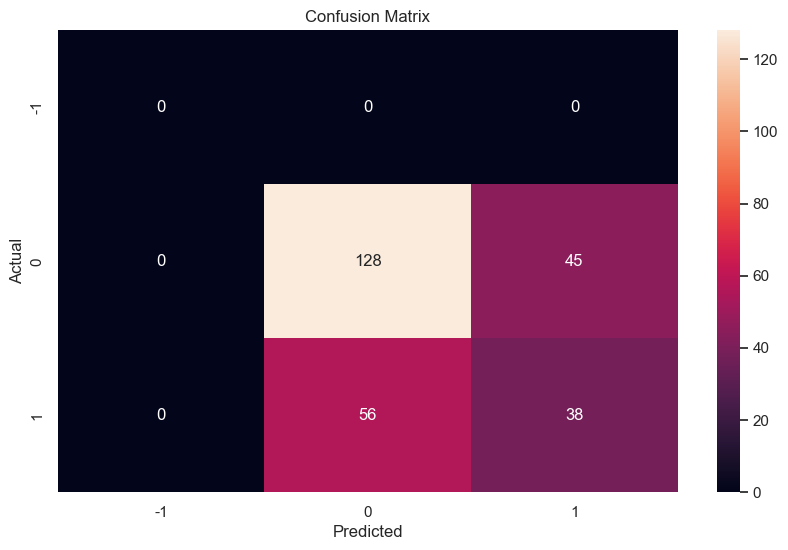

In [265]:
# plot confusion matrix

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_y, pred_y):
    cm = confusion_matrix(test_y, pred_y, labels=[-1, 0, 1])
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    # adjust labels
    plt.xticks([0.5, 1.5, 2.5], ['-1', '0', '1'])
    plt.yticks([0.5, 1.5, 2.5], ['-1', '0', '1'])
    plt.show()

plot_confusion_matrix(test_y, pred_y)